***
## **MODELIZACIÓN EXPLICATIVA DEL ATTRITION**

**Objetivo**

Cuantificar la relación entre factores organizativos y attrition mediante técnicas estadísticas, permitiendo identificar asociaciones relevantes, cuantificar la contribución relativa de cada factor y complementar los patrones observados en el análisis descriptivo.

**Alcance del notebook**

Este bloque incluye:

- Construimos modelos explicativos para estimar la relación entre variables organizativas y abandono.
- Evaluamos significancia, dirección e intensidad del efecto de cada driver.
- Analizamos importancia global y local mediante técnicas de interpretabilidad.
- Identificamos perfiles de mayor exposición al attrition.

Este análisis continúa la narrativa iniciada en el notebook descriptivo.

**Coherencia con el análisis descriptivo**

Se mantiene la misma preparación de datos, definiciones de variables y convenciones analíticas, garantizando consistencia y comparabilidad entre fases.


### ***Configuración del entorno de análisis***

Importación de librerías, configuración visual y definición de funciones auxiliares necesarias para el análisis inferencial.

In [ ]:
# ============================================================
# ENTORNO BASE — CONFIGURACIÓN GLOBAL DEL PROYECTO (GENÉRICA)
# ============================================================

# -----------------------------
# 1) Librerías base
# -----------------------------
import warnings
warnings.filterwarnings("ignore")

import math
import numpy as np
import pandas as pd

# Visualización
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.patches as mpatches
import seaborn as sns

# Estadística (tests)
from scipy.stats import chi2_contingency, mannwhitneyu
from scipy import stats

# Modelado + explainability
import shap
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


# -----------------------------
# 2) Configuración de pandas
# -----------------------------
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 200)
pd.set_option("display.width", 140)
pd.set_option("display.precision", 2)
pd.set_option("display.float_format", "{:.2f}".format)


# ============================================================
# 3) CONSTANTES VISUALES DEL PROYECTO
# ============================================================

# Fondo corporativo
BG = "#191919"

# Colores corporativos base (diccionario ampliable)
COLORS = {
    "accent_1": "#FFE2AB",   # acento cálido
    "accent_2": "#1AAEBA",   # acento frío
    "grid": "#3a3a3a",
    "text": "white",
    "edge": "white",
}

# Paleta semántica para la variable objetivo (consistente en todo el proyecto)
ATTRITION_PALETTE = {
    "Yes": COLORS["accent_1"],  # Attrition → amarillo
    "No": COLORS["accent_2"],   # No attrition → azul
}

# Ruta a la tipografía corporativa (archivo de proyecto)
FONT_PATH = (
    "../assets/fonts/"
    "static/Inter_18pt-Regular.ttf"
)


# ============================================================
# 4) RENDERIZADO TIPOGRÁFICO (ESTABILIDAD)
# ============================================================
# Ajustes para estabilidad del render con OpenType + exportación a SVG/PDF.
mpl.rcParams["text.usetex"] = False
mpl.rcParams["svg.fonttype"] = "none"
mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["text.hinting"] = "auto"


# ============================================================
# 5) APLICACIÓN DE TEMA GLOBAL (MPL manda, SNS se adapta)
# ============================================================

def _load_font(font_path: str) -> str:
    """
    Registra la tipografía corporativa en Matplotlib (si está disponible).

    Parameters
    ----------
    font_path : str
        Ruta al archivo .ttf.

    Returns
    -------
    str
        Nombre de la fuente activa. Si falla, usa 'sans-serif'.
    """
    try:
        fm.fontManager.addfont(font_path)
        return fm.FontProperties(fname=font_path).get_name()
    except Exception as e:
        print(f"[INFO] Fuente corporativa no disponible. Fallback aplicado: {e}")
        return "sans-serif"


def apply_theme_global(reset: bool = True, font_path: str = FONT_PATH) -> str:
    """
    Aplica el tema corporativo global para Matplotlib.

    Parameters
    ----------
    reset : bool, default=True
        Si True, limpia rcParams y cierra figuras antes de aplicar el tema.
    font_path : str
        Ruta de tipografía corporativa.

    Returns
    -------
    str
        Nombre de la fuente activa.
    """
    if reset:
        mpl.rcdefaults()
        plt.close("all")

    font_name = _load_font(font_path)

    plt.rcParams.update({
        # Fondos
        "figure.facecolor": BG,
        "axes.facecolor": BG,
        "savefig.facecolor": BG,

        # Tipografía base
        "font.family": font_name,
        "font.sans-serif": [font_name],
        "font.size": 11,
        "axes.titlesize": 14,
        "axes.titleweight": "bold",
        "axes.labelsize": 11,
        "legend.fontsize": 10,

        # Texto
        "text.color": COLORS["text"],
        "axes.labelcolor": COLORS["text"],
        "axes.titlecolor": COLORS["text"],
        "xtick.color": COLORS["text"],
        "ytick.color": COLORS["text"],

        # Bordes
        "axes.edgecolor": COLORS["edge"],

        # Grid
        "grid.color": COLORS["grid"],
        "grid.alpha": 0.35,

        # Leyendas
        "legend.facecolor": BG,
        "legend.edgecolor": COLORS["edge"],
    })

    return font_name


def apply_sns_defaults():
    """
    Ajusta contexto base de Seaborn (escala y proporciones) sin set_theme global,
    para evitar que Seaborn pise los rcParams corporativos de Matplotlib.
    """
    sns.set_context("notebook", font_scale=1.0)


def sns_context(style: str = "darkgrid"):
    """
    Context manager para aplicar estilos Seaborn de forma local.

    Usage
    -----
    with sns_context():
        sns.barplot(...)
    """
    return sns.axes_style(
        style,
        rc={
            "axes.facecolor": BG,
            "figure.facecolor": BG,
            "grid.color": COLORS["grid"],
            "grid.alpha": 0.35,
            "axes.edgecolor": COLORS["edge"],
            "text.color": COLORS["text"],
            "axes.labelcolor": COLORS["text"],
            "xtick.color": COLORS["text"],
            "ytick.color": COLORS["text"],
        }
    )


# ============================================================
# 6) HELPERS GENÉRICOS (REUTILIZABLES EN TODO EL PROYECTO)
# ============================================================

def new_fig(figsize=(6, 4)):
    """
    Crea una figura y eje con fondo corporativo aplicado.

    Returns
    -------
    (fig, ax)
    """
    fig, ax = plt.subplots(figsize=figsize)
    fig.patch.set_facecolor(BG)
    ax.set_facecolor(BG)
    return fig, ax


def style_axes(ax, title=None, xlabel=None, ylabel=None, rotate_xticks=0, grid=True):
    """
    Formateo genérico para ejes cartesianos (barras, líneas, scatter, regplot, etc.).

    Notes
    -----
    No se recomienda para gráficos no cartesianos (pie/donut/polar) ni para
    heatmaps muy customizados (donde puede interesar controlar ticks y grid aparte).
    """
    if title:
        ax.set_title(title, fontweight="bold")
    if xlabel is not None:
        ax.set_xlabel(xlabel)
    if ylabel is not None:
        ax.set_ylabel(ylabel)

    ax.tick_params(axis="x", rotation=rotate_xticks)

    if grid:
        ax.grid(True, axis="both", alpha=0.35)
    else:
        ax.grid(False)

    for spine in ax.spines.values():
        spine.set_alpha(0.6)

    return ax

def prepare_non_cartesian(ax, title=None):
    """
    Ajustes genéricos para gráficos no cartesianos (pie/donut/polar).

    - Mantiene proporción 1:1
    - Elimina ejes/ticks (no aportan información)
    """
    ax.set_aspect("equal")
    ax.set_axis_off()
    if title:
        ax.set_title(title, fontweight="bold", color=COLORS["text"])
    return ax


def palette_from_categories(categories, base_colors=None):
    """
    Construye una paleta determinista para una lista de categorías.

    Parameters
    ----------
    categories : iterable
        Categorías (strings o valores) a mapear a colores.
    base_colors : list[str], optional
        Lista de colores hex a utilizar. Si no se indica, se usa un set por defecto.

    Returns
    -------
    dict
        Diccionario {categoria: color}.
    """
    cats = [c for c in pd.Series(categories).dropna().astype(str).unique()]
    if base_colors is None:
        base_colors = [
            COLORS["accent_1"],
            COLORS["accent_2"],
            "#C77CFF",
            "#7CAE00",
            "#00BFC4",
            "#F8766D",
            "#00BF7D",
            "#F94144",  # rojo
            "#F3722C",  # naranja
            "#F8961E",  # ámbar
            "#F9C74F",  # amarillo vivo
            "#90BE6D",  # verde
            "#43AA8B",  # verde-agua
            "#4D908E",  # teal
            "#577590",  # azul grisáceo
            "#277DA1",  # azul
            "#3A86FF",  # azul brillante
            "#00BBF9",  # cian
            "#00F5D4",  # turquesa claro
            "#9B5DE5",  # violeta
            "#5A189A",  # púrpura oscuro
            "#C77DFF",  # lila
            "#F15BB5",  # magenta
            "#A8DADC",  # pastel frío
            "#E5989B",  # rosa apagado
            "#BDB2FF",  # lavanda
            "#B7E4C7",  # verde pastel
            "#D9ED92",  # lima pastel
            "#6C757D",  # gris neutro
        ]
    return {cat: base_colors[i % len(base_colors)] for i, cat in enumerate(cats)}


def legend(ax, labels=None, colors=None, title=None, loc="best", ncol=1, frameon=True):
    """
    Helper genérico para leyendas.

    Permite:
    - Usar la leyenda automática de Matplotlib/Seaborn (si ya hay 'handles')
    - O construir una leyenda manual a partir de etiquetas + colores (parches)

    Parameters
    ----------
    ax : matplotlib.axes.Axes
        Eje al que aplicar la leyenda.
    labels : list[str], optional
        Etiquetas para leyenda manual.
    colors : list[str], optional
        Colores para leyenda manual (hex o nombres válidos).
    title : str, optional
        Título de la leyenda.
    loc : str, default="best"
        Posición de la leyenda.
    ncol : int, default=1
        Número de columnas.
    frameon : bool, default=True
        Mostrar marco de la leyenda.
    """
    if labels is not None and colors is not None:
        handles = [mpatches.Patch(color=c, label=l) for l, c in zip(labels, colors)]
        ax.legend(handles=handles, title=title, loc=loc, ncol=ncol, frameon=frameon)
    else:
        ax.legend(title=title, loc=loc, ncol=ncol, frameon=frameon)
    return ax


def style_colorbar(cbar, label=None):
    """
    Aplica estilo corporativo a una colorbar (útil en heatmaps).

    Parameters
    ----------
    cbar : matplotlib.colorbar.Colorbar
        Colorbar a formatear.
    label : str, optional
        Etiqueta de la barra de color.
    """
    if label:
        cbar.set_label(label, color=COLORS["text"])

    cbar.ax.yaxis.set_tick_params(color=COLORS["text"])
    plt.setp(cbar.ax.get_yticklabels(), color=COLORS["text"])
    cbar.outline.set_edgecolor(COLORS["edge"])
    return cbar

def annotate_bars(ax, fmt="{:.1f}%", offset=1.9, fontsize=12, rotation=0):
    """
    Añade etiquetas de valor sobre las barras de un eje.

    Parameters
    ----------
    ax : matplotlib.axes.Axes
        Eje que contiene las barras.
    fmt : str
        Formato del valor mostrado.
    offset : float
        Distancia vertical respecto a la barra.
    fontsize : int
        Tamaño del texto.
    rotation : int or float
        Rotación de la etiqueta.
    """
    for p in ax.patches:
        h = p.get_height()
        if h > 0:
            ax.annotate(
                fmt.format(h),
                (p.get_x() + p.get_width()/2., h + offset),
                ha="center", va="bottom",
                fontsize=fontsize, color=COLORS["text"],
                rotation=rotation
            )

def corporate_heatmap(data, labels, ax, title="", cmap="YlOrRd"):
    """
    Dibuja un heatmap con estilo visual corporativo del proyecto.

    Aplica fondo oscuro, bordes definidos y formateo consistente de ejes
    para mantener coherencia estética entre visualizaciones analíticas.

    Parameters
    ----------
    data : DataFrame or array-like
        Matriz numérica usada para la intensidad de color.

    labels : DataFrame or array-like
        Anotaciones mostradas en cada celda (misma forma que `data`).

    ax : matplotlib.axes.Axes
        Eje donde se renderiza el gráfico.

    title : str, optional
        Título del heatmap.

    cmap : str or colormap, default="YlOrRd"
        Mapa de color aplicado.

    Returns
    -------
    None
    """  
    ax.set_facecolor(BG)

    sns.heatmap(
        data,
        annot=labels,
        fmt="",
        cmap=cmap,
        cbar=False,
        linewidths=0.6,
        linecolor=COLORS["edge"],
        ax=ax
    )

    style_axes(
        ax,
        title=title,
        xlabel="",
        ylabel="",
        grid=False
    )

def annotate_heatmap(ax, fmt=".2f", fontsize=9):
    """
    Ajuste de anotaciones de heatmap para buena legibilidad en fondo oscuro.

    Parameters
    ----------
    ax : matplotlib.axes.Axes
        Eje del heatmap.
    fmt : str
        Formato numérico esperado.
    fontsize : int
        Tamaño de fuente para anotación.
    """
    for t in ax.texts:
        t.set_color(COLORS["text"])
        t.set_fontsize(fontsize)
    return ax

def contrast_heatmap_text(ax, light_threshold=0.65):
    """
    Ajusta el color de cada anotación del heatmap para que contraste con el color de su celda.

    Parameters
    ----------
    ax : matplotlib.axes.Axes
        Eje donde vive el heatmap (sns.heatmap).
    light_threshold : float, default=0.65
        Umbral de luminancia (0-1). Si la celda es "clara", texto en negro; si es "oscura", texto en blanco.
    """
    if not ax.collections:
        return ax

    mesh = ax.collections[0]
    facecolors = mesh.get_facecolors()

    for i, t in enumerate(ax.texts):
        if i >= len(facecolors):
            break

        r, g, b, _ = facecolors[i]
        lum = 0.299 * r + 0.587 * g + 0.114 * b

        t.set_color("black" if lum > light_threshold else "white")

    return ax

def heatmap_attrition(df, var_y, var_x, ax, cmap="YlOrRd", min_n=20, annot_size=13):
    """
    Genera un heatmap corporativo del porcentaje de attrition ("Yes") entre dos variables categóricas,
    mostrando simultáneamente el porcentaje y el tamaño muestral (n) en cada celda.

    La función calcula el porcentaje de empleados con attrition para cada combinación de categorías
    entre `var_y` (eje vertical) y `var_x` (eje horizontal). Además, muestra el conteo absoluto de
    observaciones en cada celda e identifica con un asterisco (*) aquellas con tamaño muestral inferior
    al umbral definido en `min_n`, indicando menor robustez estadística.

    El heatmap utiliza el estilo corporativo definido en `corporate_heatmap` y aplica ajustes automáticos
    de legibilidad, incluyendo contraste del texto y rotación de etiquetas cuando hay muchas categorías.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame que contiene los datos. Debe incluir la columna 'attrition' con valores "Yes" y "No",
        así como las variables categóricas especificadas en `var_y` y `var_x`.

    var_y : str
        Nombre de la variable categórica que se representará en el eje vertical (filas).

    var_x : str
        Nombre de la variable categórica que se representará en el eje horizontal (columnas).

    ax : matplotlib.axes.Axes
        Objeto Axes sobre el que se dibujará el heatmap. Permite integrar esta función en layouts
        personalizados con múltiples subgráficos.

    cmap : str or matplotlib.colors.Colormap, optional (default="YlOrRd")
        Mapa de colores utilizado para representar la intensidad del porcentaje de attrition.

    min_n : int or None, optional (default=20)
        Umbral mínimo de tamaño muestral recomendado para interpretar los resultados con robustez.
        Las celdas con n < min_n se marcan con un asterisco (*) en la etiqueta.
        Si es None, no se aplica ninguna advertencia.

    annot_size: int or None, optional (default=13)
        Configuración del tamaño de las etiquetas de las celdas. Si es None, se aplica por defecto 13.

    Returns
    -------
    matplotlib.axes.Axes
        Objeto Axes con el heatmap generado, permitiendo modificaciones adicionales si es necesario.

    Notes
    -----
    - El porcentaje mostrado corresponde exclusivamente a la categoría 'Yes' de la variable 'attrition'.
    - Las etiquetas de cada celda siguen el formato: "XX.X% (n=YY)".
    - Si n < min_n, se añade un asterisco: "XX.X% (n=YY*)".
    - Las celdas sin observaciones se muestran como 0.0% (n=0).
    - La función depende de las funciones auxiliares:
        - corporate_heatmap()
        - annotate_heatmap()
        - contrast_heatmap_text()
    """
    # % Attrition (Yes)
    pct = (
        df.groupby([var_y, var_x])["attrition"]
          .value_counts(normalize=True)
          .mul(100)
          .rename("pct")
          .reset_index()
          .query("attrition == 'Yes'")
          .pivot(index=var_y, columns=var_x, values="pct")
          .fillna(0)
    )

    # Conteos n
    n = (
        df.groupby([var_y, var_x])
          .size()
          .rename("n")
          .reset_index()
          .pivot(index=var_y, columns=var_x, values="n")
          .reindex_like(pct)
          .fillna(0)
    )

    # Etiquetas (% + n + *)
    labels = pct.copy().astype(str)

    for r in pct.index:
        for c in pct.columns:
            val = pct.loc[r, c]
            n_val = int(n.loc[r, c])

            star = "*" if (min_n is not None and n_val < min_n) else ""
            labels.loc[r, c] = f"{val:.1f}%\n(n={n_val}{star})"

    # Plot corporativo
    corporate_heatmap(
        data=pct,
        labels=labels,
        ax=ax,
        title=f"% Attrition: \n{var_y} vs {var_x}",
        cmap=cmap
    )

    annotate_heatmap(ax, fontsize=annot_size)          
    contrast_heatmap_text(ax, light_threshold=0.65)

    # Rotación automática si muchas categorías
    if pct.shape[1] >= 6:
        ax.tick_params(axis="x", rotation=45)

    # Nota bases pequeñas
    if min_n is not None:
        ax.text(
            1.0, 1.05,
            f"* n < {min_n} (interpretar con cautela)",
            transform=ax.transAxes,
            ha="right",
            va="bottom",
            fontsize=9,
            color=COLORS["text"],
            alpha=0.9
        )

    return ax


# ============================================================
# 7) ACTIVACIÓN DEL ENTORNO
# ============================================================

FONT_NAME = apply_theme_global(reset=True, font_path=FONT_PATH)
apply_sns_defaults()

print("Entorno visual corporativo inicializado")
print("Fuente activa:", FONT_NAME)


Entorno visual corporativo inicializado
Fuente activa: Inter 18pt


### ***Carga del dataset***

**Objetivo**
Cargar el dataset procesado y confirmar su disponibilidad para la modelización.

**Qué hacemos**
- Cargamos el archivo `.csv` desde la carpeta `data/processed`.
- Verificamos dimensiones generales y disponibilidad de la variable objetivo (`attrition`).

**Cómo se interpreta**
Este paso asegura que el dataset está correctamente preparado y listo para el análisis inferencial.


In [ ]:
# 1) Carga del dataset procesado
df = pd.read_csv("../data/processed/hr_processed.csv", index_col="id")

# 2) Verificación estructural rápida
print("\n" + "-"*60)
print("Shape del dataset (filas, columnas):")
print(f"Número de filas del dataset: {df.shape[0]} filas")
print(f"Número de columnas del dataset: {df.shape[1]} columnas")

# 3) Revisión de valores nulos
nulls = df.isna().sum().sort_values(ascending=False)
nulls = nulls[nulls > 0]

print("\n" + "-"*60)
print("Columnas con valores nulos:")
display(nulls if len(nulls) > 0 else "No se detectaron valores nulos")

# 4) Validación de variable objetivo
if "attrition" not in df.columns:
    print("\n" + "-"*60)
    raise ValueError("La columna 'attrition' no está presente en el dataset")


------------------------------------------------------------
Shape del dataset (filas, columnas):
Número de filas del dataset: 1470 filas
Número de columnas del dataset: 30 columnas

------------------------------------------------------------
Columnas con valores nulos:


'No se detectaron valores nulos'

### ***Uso de variables discretizadas***

**Objetivo**

Utilizar las variables discretizadas previamente definidas en el análisis descriptivo para facilitar la interpretabilidad del modelo.

**Qué hacemos**
- Reutilizamos las variables segmentadas generadas durante el procesamiento de datos.
- Estas variables permiten representar factores organizativos en forma de categorías interpretables.

**Cómo se interpreta**

La discretización facilita la interpretación de los resultados del modelo en términos de segmentos organizativos relevantes.

In [26]:
# Nota metodológica:
# - pd.cut  → bins definidos por criterio de negocio
# - pd.qcut → bins basados en cuantiles (igual nº de observaciones)

# ------------------------------------------------------------
# Segmentación demográfica y contexto
# ------------------------------------------------------------

# Edad (segmentación generacional aproximada)
df["age_range"] = pd.cut(
    df["age"],
    bins=[0, 29, 35, 45, 100],
    labels=["<30 y.o.", "30-35", "36-45", "46+"]
)

# Distancia al trabajo (impacto potencial en desgaste)
df["distance_cat"] = pd.cut(
    df["distance_from_home"],
    bins=[0, 2, 5, 8, 16, 100],
    labels=["Very Close", "Close", "Moderate", "Far", "Very Far"]
)

# ------------------------------------------------------------
# Segmentación salarial y compensación
# ------------------------------------------------------------

# Nivel relativo de salario diario
df["daily_rate_level"] = pd.qcut(
    df["daily_rate"],
    q=4,
    labels=["Low", "Mid-Low", "Mid-High", "High"]
)

# Nivel relativo salario por hora
df["hourly_rate_level"] = pd.qcut(
    df["hourly_rate"],
    q=4,
    labels=["Low", "Mid-Low", "Mid-High", "High"]
)

# Rango de salario mensual
df["mon_income_range"] = pd.qcut(
    df["monthly_income"],
    q=4,
    labels=["Low", "Mid-Low", "Mid-High", "High"]
)

# Incremento salarial (%)
df["salary_hike_level"] = pd.cut(
    df["percent_salary_hike"],
    bins=[0, 12, 15, 20, 100],
    labels=["Low", "Mid-Low", "Mid-High", "High"]
)

# ------------------------------------------------------------
# Trayectoria profesional
# ------------------------------------------------------------

# Experiencia total
df["experience_range"] = pd.cut(
    df["total_working_years"],
    bins=[0, 5, 10, 20, 100],
    labels=["<5 Yrs", "5-10 Yrs", "11-20 Yrs", "21+ Yrs"]
)

# Nº de empresas previas (movilidad histórica)
df["num_co_segment"] = pd.cut(
    df["num_companies_worked"],
    bins=[-1, 2, 5, 100],
    labels=["0-2 Co.", "3-5 Co.", "6+ Co."]
)

# Frecuencia formación
df["training_frequency"] = pd.cut(
    df["training_times_last_year"],
    bins=[-1, 2, 4, 100],
    labels=["0-2 sessions", "3-4 sessions", "5+ sessions"]
)

# ------------------------------------------------------------
# Antigüedad y progresión interna
# ------------------------------------------------------------

# Antigüedad total en la compañía
df["seniority_range"] = pd.cut(
    df["years_at_company"],
    bins=[-1, 2, 7, 15, 100],
    labels=["<3 Yrs", "3-7 Yrs", "8-15 Yrs", "16+ Yrs"]
)

# Antigüedad en el rol actual
df["role_seniority_range"] = pd.cut(
    df["years_in_current_role"],
    bins=[-1, 2, 4, 8, 100],
    labels=["<2 Yrs", "2-4 Yrs", "5-8 Yrs", "9+ Yrs"]
)

# Tiempo desde la última promoción
df["promo_gap_range"] = pd.cut(
    df["years_since_last_promotion"],
    bins=[-1, 0, 2, 6, 100],
    labels=["<1 Yr", "1-2 Yrs", "3-6 Yrs", "7+ Yrs"]
)

# Antigüedad con el manager actual
df["manager_tenure_range"] = pd.cut(
    df["years_with_curr_manager"],
    bins=[-1, 2, 4, 8, 100],
    labels=["<2 Yrs", "2-4 Yrs", "5-8 Yrs", "9+ Yrs"]
)

### ***Orden lógico de categorías***

**Objetivo**

Mantener la consistencia en el orden de las variables categóricas utilizadas en el análisis.

**Qué hacemos**
- Reutilizamos el orden lógico de categorías definido previamente.
- Este orden garantiza coherencia en la interpretación de resultados y visualizaciones.

**Cómo se interpreta**

Asegura que las variables categóricas con progresión natural se representen de forma consistente a lo largo del análisis.

In [ ]:
# 1) Definir orden lógico de categorías

ordenes_logicos = {
    'age_range': ["<30 y.o.", "30-35", "36-45", "46+"],
    'business_travel': ['Non', 'Rarely', 'Frequently'],
    'daily_rate_level': ["Low", "Mid-Low", "Mid-High", "High"],
    'department': ["Sales", "Research & Development", "Human Resources"],
    'distance_cat': ["Very Close", "Close", "Moderate", "Far", "Very Far"], 
    'education': ['No Formal Education', 'Basic Education', 'Associate Degree', 'Bachelor Degree', 'Postgraduate'],
    'education_field': ['Life Sciences', 'Medical', 'Marketing', 'Technical Degree', 'Human Resources', 'Other', 'Unknown'],
    'environment_satisfaction': ['Not Satisfied at all', 'Dissatisfied', 'Satisfied', 'Delighted'],
    'gender': ["Female", "Male"],
    'hourly_rate_level': ["Low", "Mid-Low", "Mid-High", "High"],
    'job_involvement': ['Not Satisfied at all', 'Dissatisfied', 'Satisfied', 'Delighted'],
    'job_level': ['Entry Level', 'Junior', 'Senior', 'Manager', 'Executive'],
    'job_role': [
        'Sales Executive','Research Scientist','Laboratory Technician',
        'Manufacturing Director','Healthcare Representative','Manager',
        'Sales Representative','Research Director','Human Resources'
    ],
    'job_satisfaction': ['Not Satisfied at all', 'Dissatisfied', 'Satisfied', 'Delighted', 'Unknown'],
    'marital_status': ['Single', 'Married', 'Divorced', 'Unknown'],
    'mon_income_range': ["Low", "Mid-Low", "Mid-High", "High"],
    'num_co_segment': ["0-2 Co.", "3-5 Co.", "6+ Co."],
    'over_time': ["No", "Yes"],
    'salary_hike_level': ["Low", "Mid-Low", "Mid-High", "High"],
    'performance_rating': ['Not Satisfied at all', 'Dissatisfied', 'Satisfied', 'Delighted'],
    'relationship_satisfaction': ['Not Satisfied at all', 'Dissatisfied', 'Satisfied', 'Delighted'],
    'stock_option_level': ['Unvested', 'Basic', 'Intermediate', 'Executive'],
    'experience_range': ["<5 Yrs", "5-10 Yrs", "11-20 Yrs", "21+ Yrs"],
    'training_frequency': ["0-2 sessions", "3-4 sessions", "5+ sessions"],
    'work_life_balance': ['Not Satisfied at all', 'Dissatisfied', 'Satisfied', 'Delighted'],
    'seniority_range': ["<3 Yrs", "3-7 Yrs", "8-15 Yrs", "16+ Yrs"],
    'role_seniority_range': ["<2 Yrs", "2-4 Yrs", "5-8 Yrs", "9+ Yrs"],
    'promo_gap_range': ["<1 Yr", "1-2 Yrs", "3-6 Yrs", "7+ Yrs"],
    'manager_tenure_range': ["<2 Yrs", "2-4 Yrs", "5-8 Yrs", "9+ Yrs"]
}

# 2) Aplicar orden categórico

for columna, orden in ordenes_logicos.items():

    # Aplicar solo si la columna está presente
    if columna in df.columns:
        df[columna] = pd.Categorical(
            df[columna],
            categories=orden,
            ordered=True
        )


### ***Definición de variables explicativas***

**Objetivo**

Centralizar las variables utilizadas como factores explicativos en la modelización del attrition.

**Qué hacemos**
- Definimos el conjunto de variables candidatas para el modelo.
- Esta lista actúa como referencia única para garantizar consistencia en el análisis inferencial.

**Cómo se interpreta**

Estas variables representan los factores sociodemográficos y organizativos evaluados en relación con el attrition.

In [28]:
columnas_analizar = [
    "age_range",
    "business_travel",
    "daily_rate_level",
    "department",
    "distance_cat",
    "education",
    "education_field",
    "environment_satisfaction",
    "gender",
    "hourly_rate_level",
    "job_involvement",
    "job_level",
    "job_role",
    "job_satisfaction",
    "marital_status",
    "mon_income_range",
    "num_co_segment",
    "over_time",
    "salary_hike_level",
    "performance_rating",
    "relationship_satisfaction",
    "stock_option_level",
    "experience_range",
    "training_frequency",
    "work_life_balance",
    "seniority_range",
    "role_seniority_range",
    "promo_gap_range",
    "manager_tenure_range",
]

# Comprobación rápida: columnas inexistentes (si hay, se revisa antes de seguir)
missing_cols = [c for c in columnas_analizar if c not in df.columns]
if missing_cols:
    raise ValueError(f"Estas columnas no existen en el dataset: {missing_cols}")

print(f"Variables definidas para análisis: {len(columnas_analizar)}")

Variables definidas para análisis: 29


***

## **FASE ANALÍTICA**

En esta fase se avanza desde la exploración hacia la cuantificación estadística de relaciones, utilizando modelos explicativos que permitan evaluar la contribución relativa de cada factor asociado al attrition.

El análisis se estructura progresivamente en:

- Modelización explicativa del abandono  
- Interpretabilidad de drivers y efectos  
- Identificación de perfiles de riesgo  

El objetivo es estimar el peso relativo de los factores organizativos dentro de un marco multivariable que complemente el análisis descriptivo ya realizado.

### **1️⃣ MODELIZACIÓN EXPLICATIVA: BASELINE LOGÍSTICO DEL ATTRITION**

**Objetivo**  
Estimar la asociación entre las características organizativas y la probabilidad de attrition, evaluando el efecto independiente de cada factor al controlar por el resto de variables del modelo.

**Qué hacemos**  
- Ajustamos una regresión logística utilizando todas las variables explicativas definidas previamente.
- Codificamos automáticamente las variables categóricas mediante One-Hot Encoding.
- Estimamos un coeficiente para cada categoría, que refleja su asociación con el attrition.
- Convertimos los coeficientes a *odds ratio* para facilitar su interpretación.
- Construimos un ranking de factores según su dirección e intensidad de asociación.

**Qué devuelve el modelo**

El modelo genera, para cada categoría:

- **Coeficiente (log-odds)** → medida base de asociación con el attrition  
- **Odds Ratio (OR)** → factor multiplicativo sobre el riesgo relativo  
- **Dirección** → indica si la categoría se asocia con mayor o menor attrition  
- **Magnitud** → clasificación del efecto (débil, moderado, relevante, fuerte)

Además, se visualizan los factores más asociados con mayor y menor attrition.

**Cómo se interpreta**

- **Coeficiente positivo (OR > 1)** → mayor asociación con attrition  
- **Coeficiente negativo (OR < 1)** → menor asociación con attrition  
- **Coeficiente cercano a 0 (OR ≈ 1)** → asociación débil o neutra  

La magnitud del efecto se interpreta mediante el Odds Ratio:

- OR = 1.20 → asociación con ~20% mayor riesgo relativo  
- OR = 2.00 → asociación con el doble de riesgo relativo  
- OR = 0.50 → asociación con la mitad del riesgo relativo  

Este modelo permite identificar qué características organizativas se asocian más estrechamente con el attrition, considerando simultáneamente todos los factores incluidos.

,Variable,Coef_logodds,Odds_Ratio,Dirección,Magnitud,Lectura ejecutiva
0,business_travel_Non,-1.53,0.22,↓ Reduce attrition,Fuerte,Reduce el riesgo a ~x0.22
1,job_role_Research Director,-1.22,0.30,↓ Reduce attrition,Fuerte,Reduce el riesgo a ~x0.30
2,job_level_Junior,-1.06,0.35,↓ Reduce attrition,Fuerte,Reduce el riesgo a ~x0.35
3,job_level_Manager,-1.04,0.35,↓ Reduce attrition,Fuerte,Reduce el riesgo a ~x0.35
4,education_field_Unknown,-0.81,0.44,↓ Reduce attrition,Relevante,Reduce el riesgo a ~x0.44
5,business_travel_Rarely,-0.78,0.46,↓ Reduce attrition,Relevante,Reduce el riesgo a ~x0.46
6,training_frequency_5+ sessions,-0.63,0.53,↓ Reduce attrition,Relevante,Reduce el riesgo a ~x0.53
7,role_seniority_range_9+ Yrs,-0.60,0.55,↓ Reduce attrition,Relevante,Reduce el riesgo a ~x0.55
8,seniority_range_3-7 Yrs,-0.57,0.57,↓ Reduce attrition,Relevante,Reduce el riesgo a ~x0.57
9,salary_hike_level_Mid-Low,-0.53,0.59,↓ Reduce attrition,Relevante,Reduce el riesgo a ~x0.59


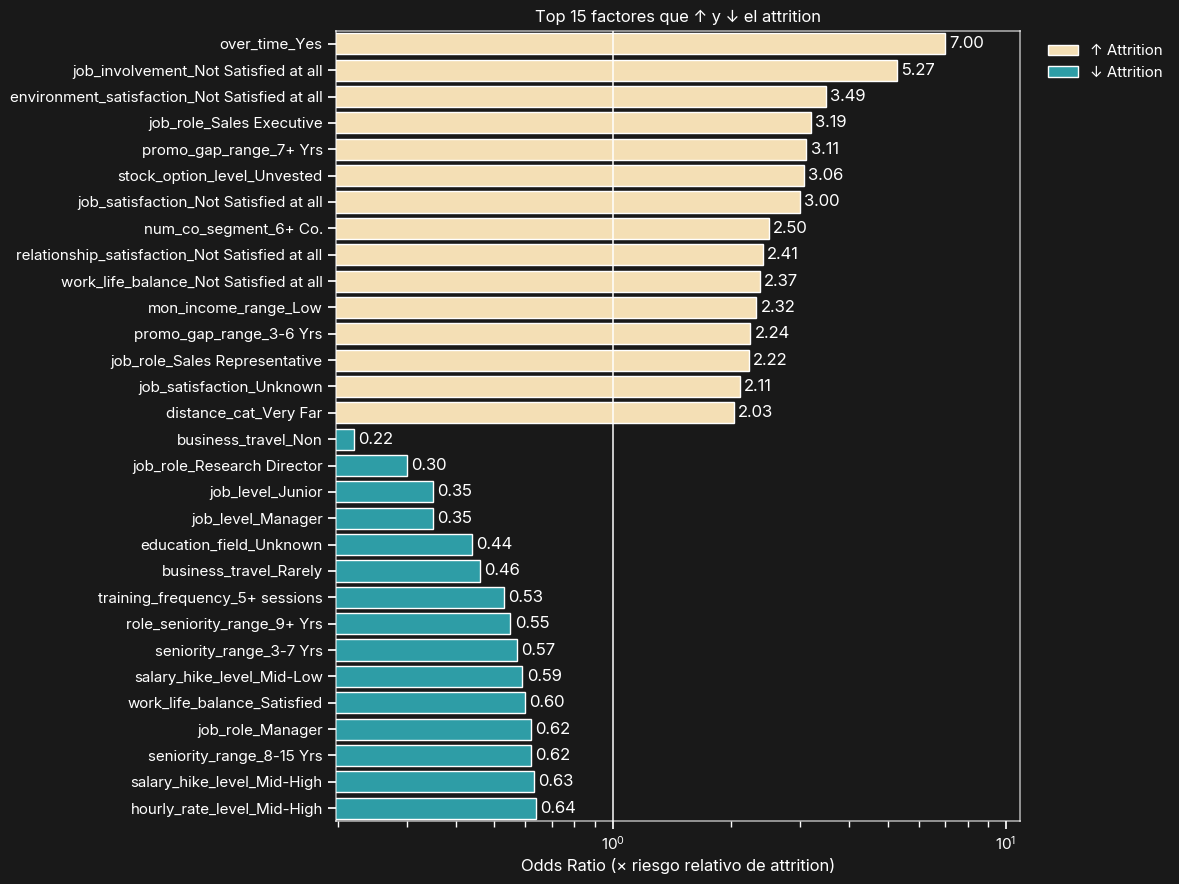

In [29]:
# Regresión logística (baseline multivariable) + Ranking de coeficientes
# amarillo = ↑ attrition (coef > 0) | azul = ↓ attrition (coef < 0)

# 1) Preparar factores (X) y target objetivo: attrition (y)
X = df[columnas_analizar].copy()
y = (df["attrition"] == "Yes").astype(int)

# 2) Pipeline: One-Hot (categóricas) + Logistic Regression (variable dependiente es dicotómica)
pipe = Pipeline([
    ("enc", OneHotEncoder(drop="first", handle_unknown="ignore")),
    ("logit", LogisticRegression(max_iter=2000))
])
pipe.fit(X, y)

# 3) Extraer modelo entrenado
enc = pipe.named_steps["enc"]
logit = pipe.named_steps["logit"]

# 4) Coeficientes por factor individual
feature_names = enc.get_feature_names_out(columnas_analizar)
coef = logit.coef_[0]

# 5) Tabla interpretable: coef (log-odds) + Odds Ratio + lectura ejecutiva
coef_df = pd.DataFrame({
    "Variable": feature_names,
    "Coef_logodds": coef
})

# Odds Ratio: exp(coef) -> factor multiplicativo sobre las odds
coef_df["Odds_Ratio"] = np.exp(coef_df["Coef_logodds"])

# Dirección (impacto sobre attrition)
coef_df["Dirección"] = np.where(
    coef_df["Coef_logodds"] > 0, "↑ Aumenta attrition", "↓ Reduce attrition"
)

# Magnitud (por |coef|, lectura rápida)
abs_coef = coef_df["Coef_logodds"].abs()
coef_df["Magnitud"] = np.select(
    [abs_coef < 0.20, abs_coef < 0.50, abs_coef < 1.00],
    ["Débil", "Moderada", "Relevante"],
    default="Fuerte"
)

# Lectura ejecutiva (OR)
def interpret_row(row):
    or_val = row["Odds_Ratio"]
    return (f"Incrementa el riesgo ~x{or_val:.2f}"
            if row["Coef_logodds"] > 0
            else f"Reduce el riesgo a ~x{or_val:.2f}")

coef_df["Lectura ejecutiva"] = coef_df.apply(interpret_row, axis=1)

# Formato final
coef_df = (
    coef_df.sort_values("Coef_logodds")
           .reset_index(drop=True)
)
coef_df["Coef_logodds"] = coef_df["Coef_logodds"].round(3)
coef_df["Odds_Ratio"] = coef_df["Odds_Ratio"].round(2)

display(coef_df)

# 6) Plot: extremos (TOP que más ↑ y TOP que más ↓)
TOP = 15
top_pos = coef_df.sort_values("Coef_logodds", ascending=False).head(TOP)  # ↑
top_neg = coef_df.sort_values("Coef_logodds", ascending=True).head(TOP)   # ↓

plot_df = (
    pd.concat([top_pos, top_neg], ignore_index=True)
      .rename(columns={"Coef_logodds": "coef", "Variable": "variable"})
      .sort_values("coef")
      .reset_index(drop=True)
)

# Dirección basada en OR (referencia = 1)
plot_df = plot_df.copy()
plot_df["direction"] = np.where(plot_df["Odds_Ratio"] >= 1, "↑ Attrition", "↓ Attrition")

palette_dir = {
    "↑ Attrition": ATTRITION_PALETTE["Yes"],
    "↓ Attrition": ATTRITION_PALETTE["No"]
}

# Orden: primero los que más ↑ (OR alto), luego los que más ↓ (OR bajo)
top_up = (plot_df[plot_df["Odds_Ratio"] >= 1]
          .sort_values("Odds_Ratio", ascending=False))

top_down = (plot_df[plot_df["Odds_Ratio"] < 1]
            .sort_values("Odds_Ratio", ascending=True))

plot_df_ord = pd.concat([top_up, top_down], axis=0)

fig, ax = new_fig(figsize=(12, 9))

sns.barplot(
    data=plot_df_ord,
    x="Odds_Ratio",
    y="variable",
    hue="direction",
    palette=palette_dir,
    dodge=False,
    edgecolor=COLORS["edge"],
    ax=ax
)

# Referencia neutra (OR = 1)
ax.axvline(1, color=COLORS["edge"], linewidth=1.2, alpha=0.9)

# Escala log
ax.set_xscale("log")

style_axes(
    ax,
    title=f"Top {TOP} factores que ↑ y ↓ el attrition",
    xlabel="Odds Ratio (× riesgo relativo de attrition)",
    ylabel="",
    grid=False
)

# Etiquetas
for container in ax.containers:
    ax.bar_label(container, fmt="%.2f", padding=3, color=COLORS["text"])

# Límites basados en OR 
xmin = max(0.1, plot_df_ord["Odds_Ratio"].min() * 0.9)
xmax = plot_df_ord["Odds_Ratio"].max() * 1.15
ax.set_xlim(xmin, xmax * 1.35)

# Leyenda
ax.legend(title="", frameon=False, loc="upper left", bbox_to_anchor=(1.02, 1.0))

plt.tight_layout()
plt.show()

#### **Principales Insights**
El modelo logístico multivariable identifica un conjunto claro de factores estructurales, organizativos y experienciales asociados al attrition, destacando especialmente los relacionados con carga laboral, clima organizativo y progresión profesional.

##### **Factores más fuertemente asociados a mayor attrition**

**Sobrecarga laboral (driver dominante)**: Es el factor más relevante del modelo y posiciona la presión operativa sostenida como el principal factor asociado a la salida.

- Realizar horas extra multiplica el riesgo relativo de attrition (~x7)
- Muy baja implicación laboral (~x5.3)
- Muy baja satisfacción con el entorno laboral (~x3.5)

**Clima organizativo negativo**: Los indicadores de experiencia subjetiva presentan asociaciones fuertes, lo que indica que el attrition está estrechamente vincualdo a la percepción negativa del entorno laboral.

- Muy baja satisfacción laboral (~x3.0)
- Muy mala calidad relacional (~x2.4)
- Desequilibrio vida–trabajo severo (~x2.4)

**Estancamiento profesional y recompensas insuficientes**: La falta de progresión y reconocimiento se asocia consistentemente con mayor salida.:

- Periodos prolongados sin promoción (~x3.1)
- Nivel salarial bajo (~x2.3)
- Incentivos no consolidados (~x3.1)
- Trayectorias laborales fragmentadas (~x2.5)

**Factores estructurales y de fricción operativa**: Condiciones externas y del puesto también contribuyen:

- Distancias muy largas al trabajo (~x2.0)
- Roles comerciales y operativos presentan mayor rotación estructural
- Menor experiencia organizativa y perfiles más jóvenes muestran mayor movilidad




##### **Factores asociados a menor attrition**

**Estabilidad y consolidación organizativa**: Los factores más protectores incluyen:

Los factores más protectores incluyen:

- Mayor senioridad y experiencia organizativa
- Roles de mayor responsabilidad técnica o directiva
- Trayectorias profesionales consolidadas

**Desarrollo, reconocimiento y condiciones favorables**: Elementos organizativos asociados a menor attrition:

- Alta frecuencia formativa
- Incrementos salariales moderados o altos
- Buen equilibrio vida–trabajo
- Menor necesidad de viajar
- Mayor proximidad al centro de trabajo


<hr style="height:1px;border:none;background-color:#444;">

### **2️⃣ ANALISIS SHAP (Shapley Values)**

**Objetivo**  
Descomponer las predicciones del modelo para identificar cómo cada variable contribuye al riesgo estimado de attrition a nivel individual, complementando la visión global obtenida mediante la regresión logística.

**Qué hacemos**  
- Aplicamos SHAP (Shapley Additive Explanations) sobre el modelo entrenado.
- Calculamos la contribución de cada variable a la predicción de attrition para cada empleado.
- Cuantificamos tanto la dirección como la magnitud del impacto de cada factor.
- Visualizamos la importancia global y el efecto individual de las variables.

**Qué devuelve el análisis**

Para cada variable y cada observación, SHAP proporciona:

- **Valor SHAP** → contribución específica de la variable al riesgo estimado
- **Dirección del impacto** → indica si la variable aumenta o reduce el riesgo
- **Magnitud del impacto** → intensidad de la contribución al resultado final

A nivel agregado, permite construir un ranking de variables según su influencia global en las predicciones.

**Cómo se interpreta**

- **Valor SHAP positivo** → la variable aumenta el riesgo estimado de attrition  
- **Valor SHAP negativo** → la variable reduce el riesgo estimado de attrition  
- **Valor SHAP cercano a 0** → impacto marginal o neutro  

Cada predicción individual puede entenderse como la suma de las contribuciones de todas las variables. Esto permite explicar el riesgo estimado no solo a nivel global, sino también a nivel individual, identificando qué factores específicos impulsan o reducen la probabilidad de attrition en cada caso.

El análisis SHAP complementa la regresión logística al aportar explicabilidad local, facilitando la comprensión detallada de los drivers del attrition y la identificación de perfiles de mayor exposición.

,feature,parent,mean_abs_shap,mean_shap,Dirección,Magnitud,Lectura ejecutiva
0,over_time_Yes,over_time,0.77,0.01,↑ Aumenta attrition,Fuerte,Asociación Fuerte que aumenta el attrition
1,stock_option_level_Unvested,stock_option_level,0.56,-0.07,↓ Reduce attrition,Relevante,Asociación Relevante que reduce el attrition
2,job_level_Junior,job_level,0.50,0.05,↑ Aumenta attrition,Relevante,Asociación Relevante que aumenta el attrition
3,environment_satisfaction_Not Satisfied at all,environment_satisfaction,0.45,-0.10,↓ Reduce attrition,Relevante,Asociación Relevante que reduce el attrition
4,job_role_Sales Executive,job_role,0.42,-0.03,↓ Reduce attrition,Relevante,Asociación Relevante que reduce el attrition
5,business_travel_Rarely,business_travel,0.32,-0.03,↓ Reduce attrition,Relevante,Asociación Relevante que reduce el attrition
6,job_satisfaction_Not Satisfied at all,job_satisfaction,0.32,0.04,↑ Aumenta attrition,Relevante,Asociación Relevante que aumenta el attrition
7,mon_income_range_Low,mon_income_range,0.31,0.02,↑ Aumenta attrition,Relevante,Asociación Relevante que aumenta el attrition
8,seniority_range_3-7 Yrs,seniority_range,0.27,0.00,↑ Aumenta attrition,Moderada,Asociación Moderada que aumenta el attrition
9,relationship_satisfaction_Not Satisfied at all,relationship_satisfaction,0.27,-0.00,↓ Reduce attrition,Moderada,Asociación Moderada que reduce el attrition


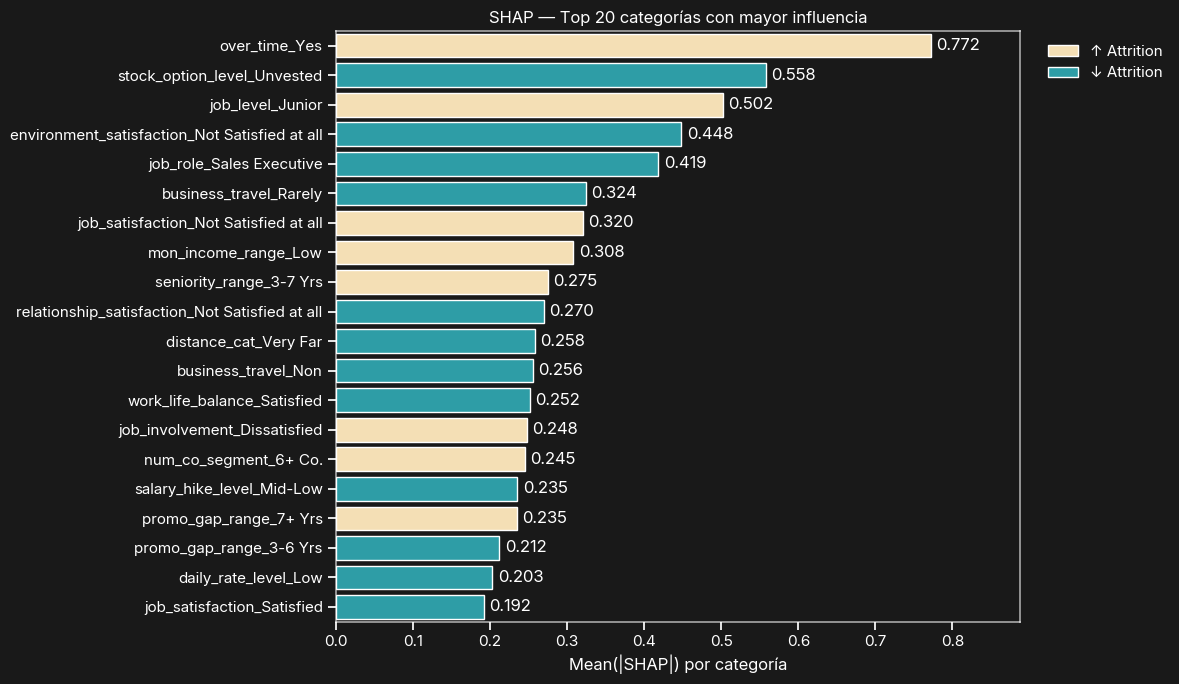

In [33]:
# 1) Preparar X, y (misma definición que en la regresión)
X = df[columnas_analizar].copy()
y = (df["attrition"] == "Yes").astype(int)

# 2) Extraer encoder + modelo del pipeline ya entrenado con la regresión
enc = pipe.named_steps["enc"]
logit = pipe.named_steps["logit"]

# 3) Transformación one-hot (misma que en el modelo)
X_enc = enc.transform(X)
feature_names = enc.get_feature_names_out(columnas_analizar)

# 4) Explainer SHAP para modelo lineal (logit sobre matriz codificada)
# Nota: si tu versión de SHAP da error con sparse, usa: X_enc = X_enc.toarray()
explainer = shap.LinearExplainer(logit, X_enc, feature_names=feature_names)
sv = explainer(X_enc)  # shap.Explanation

# 5) Agrupar dummies por variable original (robusto con underscores)
orig_cols = list(X.columns)

def parent_var(feat_name: str, orig_cols=orig_cols) -> str:
    """Devuelve la variable original ('padre') de una feature one-hot."""
    for c in orig_cols:
        if feat_name == c or feat_name.startswith(c + "_"):
            return c
    return feat_name

parents = np.array([parent_var(f) for f in feature_names])

# Valores SHAP (n_samples, n_features)
vals = sv.values

# 6) TABLAS: dummy-level

# Métricas base
mean_abs_shap = np.abs(vals).mean(axis=0)  # importancia global (sin dirección)
mean_shap = vals.mean(axis=0)              # dirección promedio

# Tabla por dummy (categoría concreta)
shap_dummy = pd.DataFrame({
    "feature": feature_names,
    "parent": parents,
    "mean_abs_shap": mean_abs_shap,
    "mean_shap": mean_shap
})

# Dirección del impacto
shap_dummy["Dirección"] = np.where(
    shap_dummy["mean_shap"] > 0,
    "↑ Aumenta attrition",
    "↓ Reduce attrition"
)

# Magnitud (por mean_abs_shap)
shap_dummy["Magnitud"] = pd.cut(
    shap_dummy["mean_abs_shap"],
    bins=[-np.inf, 0.15, 0.30, 0.60, np.inf],
    labels=["Marginal", "Moderada", "Relevante", "Fuerte"]
)

# Lectura ejecutiva
def interpret_shap(row):
    verb = "aumenta" if row["mean_shap"] > 0 else "reduce"
    return f"Asociación {row['Magnitud']} que {verb} el attrition"

shap_dummy["Lectura ejecutiva"] = shap_dummy.apply(interpret_shap, axis=1)

# Orden final
shap_dummy = (
    shap_dummy.sort_values("mean_abs_shap", ascending=False)
              .reset_index(drop=True)
)

display(shap_dummy.head(30))

# 7) Plot corporativo — importancia global dummy-level (categorías)
TOP = 20

plot_dummy = (
    shap_dummy
      .head(TOP)  
      .copy()
      .sort_values("mean_abs_shap", ascending=False)  
)

# Colores por dirección (según mean_shap)
plot_dummy["direction"] = np.where(plot_dummy["mean_shap"] > 0, "↑ Attrition", "↓ Attrition")
palette_dir = {"↑ Attrition": ATTRITION_PALETTE["Yes"], "↓ Attrition": ATTRITION_PALETTE["No"]}

fig, ax = new_fig(figsize=(12, 7))
ax.set_facecolor(BG)

sns.barplot(
    data=plot_dummy,
    x="mean_abs_shap",
    y="feature",
    hue="direction",
    palette=palette_dir,
    dodge=False,
    edgecolor=COLORS["edge"],
    ax=ax
)

style_axes(
    ax,
    title=f"SHAP — Top {TOP} categorías con mayor influencia",
    xlabel="Mean(|SHAP|) por categoría",
    ylabel="",
    grid=False
)

# Etiquetas y margen derecho 
for container in ax.containers:
    ax.bar_label(container, fmt="%.3f", padding=4, color=COLORS["text"])

xmax = plot_dummy["mean_abs_shap"].max()
ax.set_xlim(0, xmax * 1.15) 

# Leyenda
ax.legend(title="", frameon=False, loc="upper left", bbox_to_anchor=(1.02, 1.0))

plt.tight_layout()
plt.show()


#### **Principales Insights**

**Relación entre regresión logística y SHAP**: La regresión logística y el análisis SHAP operan sobre las mismas condiciones (categorías), pero aportan perspectivas complementarias sobre el attrition. Mientras la **regresión logística** cuantifica cuánto aumenta o reduce el riesgo una condición concreta; el **análisis SHAP** indica qué condiciones están influyendo más en las predicciones del modelo.

En este análisis, ambos enfoques identifican patrones consistentes, confirmando que factores como la carga operativa, el nivel de satisfacción, la progresión profesional y las condiciones económicas desempeñan un papel central en el attrition.

Esta coherencia refuerza la solidez del modelo y permite interpretar los resultados con mayor confianza.


<hr style="height:1px;border:none;background-color:#444;">

### **3️⃣ IDENTIFICACIÓN DE PERFILES DE RIESGO: CLUSTERIZACIÓN BASADA EN SHAP**


**Objetivo**  
Segmentar empleados en perfiles homogéneos según su riesgo estimado de attrition y los patrones que lo explican, para transformar resultados del modelo en colectivos accionables.

**Qué hacemos**  
- Calculamos el **riesgo individual** (probabilidad predicha) con el modelo logístico entrenado.
- Construimos un dataset de **explicaciones SHAP por empleado**, que resume qué factores empujan o reducen el riesgo en cada caso.
- Aplicamos **clustering** sobre los perfiles SHAP (con escalado y PCA) para agrupar empleados con patrones explicativos similares.
- Generamos un **resumen por cluster** (tamaño, riesgo medio y tasa observada de attrition) y extraemos los **drivers SHAP principales** de cada perfil.

**Qué obtenemos**  
- Una etiqueta `risk_cluster` por empleado (perfil de riesgo).
- Una métrica `attrition_risk` por empleado (riesgo predicho).
- Un resumen por cluster con:
  - **n** (tamaño del grupo)
  - **riesgo medio predicho**
  - **attrition observado (%)**
- Un ranking de **factores que caracterizan cada perfil**, basado en SHAP (dirección e intensidad).

**Cómo se interpreta**  
- Clusters con **riesgo medio más alto** representan perfiles con mayor exposición al attrition.
- Los **drivers SHAP por cluster** permiten entender qué condiciones concretas caracterizan ese perfil
  (p. ej., sobrecarga operativa, clima negativo, falta de progresión, fricción logística).
- El cruce entre **riesgo predicho** y **attrition observado** facilita priorizar perfiles relevantes para intervención.

PCA: componentes retenidos = 57 (>=90% varianza)


,risk_cluster,n,attrition_rate,risk_mean,risk_p25,risk_p50,risk_p75
1,1,722,22.40,0.22,0.04,0.12,0.35
0,0,540,10.90,0.11,0.01,0.04,0.12
2,2,208,7.70,0.07,0.01,0.02,0.08


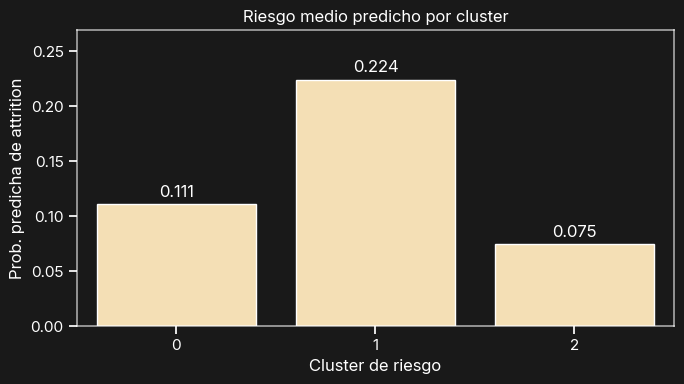


----------------------------------------------------------------------
Cluster 0 — Top drivers SHAP (dirección e intensidad)


,feature,mean_shap,Dirección,intensidad_abs
0,job_level_Junior,-0.19,↓ Reduce attrition,0.19
1,seniority_range_8-15 Yrs,-0.18,↓ Reduce attrition,0.18
2,environment_satisfaction_Not Satisfied at all,-0.16,↓ Reduce attrition,0.16
3,job_role_Sales Executive,0.15,↑ Empuja a attrition,0.15
4,mon_income_range_Low,-0.12,↓ Reduce attrition,0.12
5,promo_gap_range_7+ Yrs,0.11,↑ Empuja a attrition,0.11
6,manager_tenure_range_5-8 Yrs,0.11,↑ Empuja a attrition,0.11
7,stock_option_level_Unvested,-0.11,↓ Reduce attrition,0.11
8,seniority_range_3-7 Yrs,0.07,↑ Empuja a attrition,0.07
9,role_seniority_range_5-8 Yrs,-0.07,↓ Reduce attrition,0.07



----------------------------------------------------------------------
Cluster 1 — Top drivers SHAP (dirección e intensidad)


,feature,mean_shap,Dirección,intensidad_abs
0,mon_income_range_Low,0.18,↑ Empuja a attrition,0.18
1,job_role_Sales Executive,-0.13,↓ Reduce attrition,0.13
2,promo_gap_range_3-6 Yrs,-0.13,↓ Reduce attrition,0.13
3,promo_gap_range_7+ Yrs,-0.12,↓ Reduce attrition,0.12
4,seniority_range_8-15 Yrs,0.12,↑ Empuja a attrition,0.12
5,job_level_Junior,0.12,↑ Empuja a attrition,0.12
6,seniority_range_3-7 Yrs,-0.08,↓ Reduce attrition,0.08
7,experience_range_<5 Yrs,0.08,↑ Empuja a attrition,0.08
8,manager_tenure_range_5-8 Yrs,-0.08,↓ Reduce attrition,0.08
9,role_seniority_range_9+ Yrs,0.07,↑ Empuja a attrition,0.07



----------------------------------------------------------------------
Cluster 2 — Top drivers SHAP (dirección e intensidad)


,feature,mean_shap,Dirección,intensidad_abs
0,job_level_Manager,-0.49,↓ Reduce attrition,0.49
1,job_level_Junior,0.43,↑ Empuja a attrition,0.43
2,experience_range_21+ Yrs,-0.31,↓ Reduce attrition,0.31
3,job_role_Research Director,-0.26,↓ Reduce attrition,0.26
4,promo_gap_range_7+ Yrs,0.25,↑ Empuja a attrition,0.25
5,job_role_Manager,-0.20,↓ Reduce attrition,0.20
6,mon_income_range_Low,-0.19,↓ Reduce attrition,0.19
7,job_role_Sales Executive,-0.17,↓ Reduce attrition,0.17
8,role_seniority_range_9+ Yrs,-0.12,↓ Reduce attrition,0.12
9,stock_option_level_Unvested,-0.11,↓ Reduce attrition,0.11


In [42]:
# 1) Riesgo individual (probabilidad predicha)
df_risk = df.copy()
df_risk["attrition_risk"] = pipe.predict_proba(X)[:, 1]


# 2) Dataset de explicaciones SHAP (por empleado)
# Cada fila = "perfil explicativo" del riesgo de ese empleado
shap_df = pd.DataFrame(
    sv.values,
    columns=feature_names,
    index=df_risk.index
)

# 3) Preprocesado para clustering
#    - Escalado (recomendado para KMeans)
#    - PCA opcional para compactar y estabilizar clusters
scaler = StandardScaler()
shap_scaled = scaler.fit_transform(shap_df)

# PCA: mantenemos varianza alta sin sobredimensionar
pca = PCA(n_components=0.90, random_state=42)  # conserva ~90% varianza
shap_pca = pca.fit_transform(shap_scaled)

print(f"PCA: componentes retenidos = {shap_pca.shape[1]} (>=90% varianza)")

# 4) Entrenar clustering final
#    - Puedes fijar K a mano o elegir el mejor por silhouette
K = 3
kmeans = KMeans(n_clusters=K, random_state=42, n_init=20)
df_risk["risk_cluster"] = kmeans.fit_predict(shap_pca)

# 5) Resumen ejecutivo de clusters
cluster_summary = (
    df_risk.assign(attr_yes=(df_risk["attrition"] == "Yes").astype(int))
           .groupby("risk_cluster", as_index=False)
           .agg(
               n=("attrition", "size"),
               attrition_rate=("attr_yes", "mean"),
               risk_mean=("attrition_risk", "mean"),
               risk_p25=("attrition_risk", lambda x: x.quantile(0.25)),
               risk_p50=("attrition_risk", "median"),
               risk_p75=("attrition_risk", lambda x: x.quantile(0.75))
           )
)

cluster_summary["attrition_rate"] = (cluster_summary["attrition_rate"] * 100).round(1)
cluster_summary[["risk_mean", "risk_p25", "risk_p50", "risk_p75"]] = cluster_summary[
    ["risk_mean", "risk_p25", "risk_p50", "risk_p75"]
].round(3)

display(cluster_summary.sort_values("risk_mean", ascending=False))

# Plot corporativo: riesgo medio por cluster
plot_cs = cluster_summary.sort_values("risk_mean", ascending=False)

fig, ax = new_fig(figsize=(7, 4))
ax.set_facecolor(BG)

sns.barplot(
    data=plot_cs,
    x="risk_cluster",
    y="risk_mean",
    color=COLORS["accent_1"],
    edgecolor=COLORS["edge"],
    ax=ax
)

ymax = plot_cs["risk_mean"].max()
ax.set_ylim(0, ymax * 1.20)

style_axes(
    ax,
    title="Riesgo medio predicho por cluster",
    xlabel="Cluster de riesgo",
    ylabel="Prob. predicha de attrition",
    grid=False
)

for container in ax.containers:
    ax.bar_label(container, fmt="%.3f", padding=3, color=COLORS["text"])

plt.tight_layout()
plt.show()

# 6) Interpretación: top factores SHAP por cluster
#    (qué “explica” el riesgo dentro de cada perfil)
shap_with_cluster = shap_df.copy()
shap_with_cluster["risk_cluster"] = df_risk["risk_cluster"].values

# Media SHAP firmada por cluster (dirección)
cluster_shap_mean = (
    shap_with_cluster.groupby("risk_cluster").mean(numeric_only=True)
)

def top_shap_drivers(cluster_id, top=10):
    s = cluster_shap_mean.loc[cluster_id].sort_values(key=np.abs, ascending=False).head(top)
    out = pd.DataFrame({
        "feature": s.index,
        "mean_shap": s.values,
        "Dirección": np.where(s.values > 0, "↑ Empuja a attrition", "↓ Reduce attrition"),
        "intensidad_abs": np.abs(s.values)
    }).sort_values("intensidad_abs", ascending=False)
    out["mean_shap"] = out["mean_shap"].round(3)
    out["intensidad_abs"] = out["intensidad_abs"].round(3)
    return out

# Mostrar top drivers por cluster (tabla)
for c in sorted(df_risk["risk_cluster"].unique()):
    print("\n" + "-"*70)
    print(f"Cluster {c} — Top drivers SHAP (dirección e intensidad)")
    display(top_shap_drivers(c, top=12))

#### **Principales insights**

El clustering basado en las explicaciones SHAP del modelo permite segmentar la plantilla en **tres perfiles diferenciados según su riesgo estructural de attrition**.  
Estos perfiles se etiquetan como **Cluster 0, Cluster 1 y Cluster 2**, y presentan niveles distintos de riesgo predicho y attrition observado.

**Distribución de la plantilla por cluster**

Se identifican tres segmentos principales:

| Cluster | n empleados | % plantilla | Attrition observado | Riesgo medio predicho |
|------|------------|-------------|--------------------|----------------------|
| **Cluster 1 (alto riesgo)** | 722 | 49.1% | 22.4% | 0.22 |
| **Cluster 0 (riesgo intermedio)** | 540 | 36.7% | 10.9% | 0.11 |
| **Cluster 2 (bajo riesgo)** | 208 | 14.1% | 7.7% | 0.07 |

**Lectura clave**

- **Cluster 1** concentra el mayor riesgo y el mayor attrition observado (aprox. 1 de cada 2 empleados pertenece a este segmento).
- **Cluster 0** representa un grupo intermedio, con riesgo y attrition moderados.
- **Cluster 2** es el perfil más estable, con el menor riesgo predicho y menor attrition observado.


##### **Cluster 1 (alto riesgo, 49.1%)**: Es el grupo con mayor probabilidad estructural de attrition.

**Qué identifica a este cluster**

- El riesgo se asocia principalmente a señales de **trayectoria menos favorable** (p. ej., condiciones económicas y de progresión) y a determinadas condiciones de rol.
- En los drivers SHAP aparecen como contribuyentes relevantes:
  - **Ingresos bajos** (`mon_income_range_Low`)
  - **Niveles iniciales** (`job_level_Junior`) y menor experiencia (`experience_range_<5 Yrs`)
  - Elementos ligados a progresión y contexto organizativo (p. ej., `promo_gap_range`, `manager_tenure_range`)

**Lectura organizativa**

Este cluster representa el segmento donde el modelo concentra el riesgo de abandono. Se trata de un perfil más sensible a condiciones de progresión, recompensa y consolidación organizativa.


##### **Cluster 0 (riesgo intermedio, 36.7%)**: Representa un perfil mixto con drivers combinados.

**Qué identifica a este cluster**

- El patrón explicativo es más heterogéneo: conviven factores protectores y factores de riesgo.
- Entre los drivers SHAP aparecen:
  - Señales de **estancamiento profesional** (`promo_gap_range_7+ Yrs`, `promo_gap_range_3-6 Yrs`)
  - Condiciones de rol/contexto con contribución al riesgo (p. ej., `job_role_Sales Executive`, `manager_tenure_range_5-8 Yrs`)
  - Factores protectores ligados a consolidación (p. ej., `seniority_range_8-15 Yrs`, estabilidad en rol)

**Lectura organizativa**

Este cluster no está definido por un único mecanismo dominante, sino por una combinación de trayectoria profesional y contexto organizativo. Constituye un grupo donde el riesgo es moderado y potencialmente prevenible.


##### **Cluster 2 (bajo riesgo, 14.1%)**: Es el grupo con mayor estabilidad organizativa.

**Qué identifica a este cluster**

- Predominan factores protectores asociados a **consolidación y estabilidad**.
- En los drivers SHAP aparecen como elementos protectores:
  - **Niveles jerárquicos más altos** (`job_level_Manager`)
  - **Alta experiencia** (`experience_range_21+ Yrs`)
  - Roles y trayectorias más consolidadas (p. ej., `job_role_Research Director`, mayor seniority)

**Lectura organizativa**

Este cluster representa el núcleo más estable de la plantilla, con menor exposición estructural al attrition y mayor consolidación organizativa.

---
### **CONCLUSIONES EJECUTIVAS — SÍNTESIS DEL ANÁLISIS EXPLICATIVO Y SEGMENTACIÓN DE RIESGO**

**Objetivo**  
Integrar los hallazgos obtenidos mediante la modelización logística, el análisis SHAP y la segmentación por clustering para establecer una comprensión estructurada de los drivers del attrition y los perfiles organizativos con mayor exposición al riesgo.

#### **Principales Insights**

* El attrition responde a un **patrón estructural consistente**, donde factores como overtime, baja satisfacción, falta de progresión y determinadas condiciones del rol incrementan significativamente el riesgo de abandono.
* La regresión logística confirma que el attrition está asociado tanto a **condiciones operativas (sobrecarga, entorno laboral)** como a **factores estructurales (nivel, rol, progresión y compensación)**.
* El análisis SHAP valida estos resultados y muestra que los mismos drivers operan tanto a nivel global como individual, permitiendo identificar **qué factores explican el riesgo específico de cada empleado**.
* El clustering basado en SHAP revela que la organización no es homogénea, sino que se estructura en **tres perfiles diferenciados con distintos niveles de riesgo estructural**.
    * El cluster de mayor riesgo concentra aproximadamente la mitad de la plantilla y está caracterizado por **condiciones de menor consolidación organizativa, menor progresión y mayor sensibilidad a factores estructurales de abandono**.
    * El cluster intermedio presenta un perfil mixto, donde el riesgo emerge de la combinación de factores de trayectoria y contexto organizativo, indicando una **zona crítica de intervención preventiva**.
    * El cluster más estable corresponde a empleados con mayor consolidación organizativa, donde predominan factores protectores asociados a **experiencia, estabilidad estructural y progresión profesional consolidada**.
* La segmentación confirma que el attrition no es un fenómeno aleatorio, sino el resultado de la interacción entre **trayectoria profesional, condiciones operativas, progresión organizativa y estabilidad estructural**.
* La combinación de modelización explicativa y segmentación permite pasar de identificar drivers aislados a comprender el attrition como un fenómeno que afecta de forma diferencial a **perfiles organizativos concretos**, habilitando una base analítica sólida para estrategias de retención dirigidas.